In [2]:
"""
This notebook compares the performance of CLIPNET against Puffin.
We use averaged profiles across all 67 libraries as ground truth.
"""

'\nThis notebook compares the performance of CLIPNET against Puffin.\nWe use averaged profiles across all 67 libraries as ground truth.\n'

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, gaussian_kde
from sklearn.linear_model import LinearRegression

from matplotlib.colors import LinearSegmentedColormap
import mpl_scatter_density # needed for density scatter plots
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize

# COLORS:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list("white_viridis", [
    (0, "#ffffff"),
    (1e-20, "#440053"),
    (0.2, "#404388"),
    (0.4, "#2a788e"),
    (0.6, "#21a784"),
    (0.8, "#78d151"),
    (1, "#fde624"),
], N=256)
# "Viridis-like" colormap with white background
white_viridis_r = LinearSegmentedColormap.from_list("white_viridis", [
    (0, "#ffffff"),
    (1e-20, "#fde624"),
    (0.4, "#78d151"),
    (0.6, "#21a784"),
    (0.7, "#2a788e"),
    (0.8, "#404388"),
    (1, "#440053"),
], N=256)
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

In [4]:
# PRINT COMMANDS TO DOWNLOAD AND EXTRACT DATA

# Set scratch to where you want to download data to
SCRATCH = "/Users/adamhe/github/scratch"

URL = "https://zenodo.org/records/13771189/files"
TAR = "evaluation_metric.tar.gz"
print(f"wget {URL}/{TAR} -P {SCRATCH}")
print(f"tar -xvzf {SCRATCH}/{TAR}")

wget https://zenodo.org/records/13771189/files/evaluation_metric.tar.gz -P /Users/adamhe/github/scratch
tar -xvzf /Users/adamhe/github/scratch/evaluation_metric.tar.gz


In [142]:
# LOAD DATA

# Negative and positive bounds for model performance on correlation
mean_predictor_corr = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/mean_predictor_corrs.csv.gz"), index_col=0,
)
replicate_corr = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/replicate_pearsons.csv.gz"), index_col=0,
)

# Load model predictions
clipnet = h5py.File(
    os.path.join(SCRATCH, "evaluation_metric/fixed_uniq_windows_clipnet_test_perf.h5")
)["track_pearson"][:]
puffin = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/puffin_clipnet_test_perf.csv.gz"), header=None
)

# Load quantity predictions
clipnet_quantity = h5py.File(
    os.path.join(SCRATCH, "evaluation_metric/clipnet_test_predictions.h5")
)["quantity"]
merged_quantity = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/merged_procap_0.csv.gz"), index_col=0, header=None
).to_numpy()[:, np.r_[250:750, 1250:1750]].sum(axis=1)

log_quantity = pd.DataFrame(
    {
        "clipnet": np.log10(clipnet_quantity[:, 0]),
        "expt": np.log10(merged_quantity),
    }
)

# Load TSS predictions
clipnet_tss_pl = h5py.File(
    os.path.join(SCRATCH, "evaluation_metric/clipnet_test_predictions.h5")
)["track"][:, :500].argmax(axis=1)
clipnet_tss_mn = h5py.File(
    os.path.join(SCRATCH, "evaluation_metric/clipnet_test_predictions.h5")
)["track"][:, 500:].argmax(axis=1)
merged_tss_pl = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/merged_procap_0.csv.gz"), index_col=0, header=None
).to_numpy()[:, 250:750].argmax(axis=1)
merged_tss_mn = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/merged_procap_0.csv.gz"), index_col=0, header=None
).to_numpy()[:, 1250:1750].argmax(axis=1)

tss = pd.DataFrame(
    {
        "clipnet": np.concatenate([clipnet_tss_pl, clipnet_tss_mn]),
        "expt": np.concatenate([merged_tss_pl, merged_tss_mn]),
    }
)

/var/folders/sd/3462tpx12fbfxc_f8swcwyf40000gp/T/ipykernel_37905/2533078882.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mean_predictor_corr.mean(axis=0), color=colors[0])
/var/folders/sd/3462tpx12fbfxc_f8swcwyf40000gp/T/ipykernel_37905/2533078882.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn

0.21288294055949813 0.5698701245952852 0.7901019255482333 0.9240692449850152


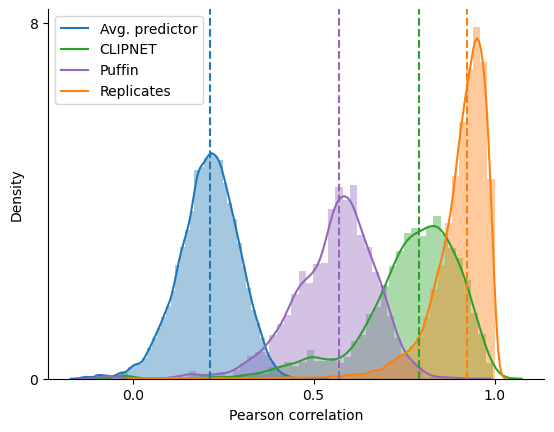

In [132]:
# Plot pdf of predicted vs observed pearson correlations

fig, d = plt.subplots()
sns.distplot(mean_predictor_corr.mean(axis=0), color=colors[0])
sns.distplot(clipnet, color=colors[2])
sns.distplot(puffin, color=colors[4])
sns.distplot(replicate_corr.values.reshape(-1), color=colors[1])
plt.axvline(np.nanmedian(mean_predictor_corr), 0, 1, color=colors[0], linestyle="--")
plt.axvline(np.nanmedian(replicate_corr), 0, 1, color=colors[1], linestyle="--")
plt.axvline(np.nanmedian(clipnet), 0, 1, color=colors[2], linestyle="--")
plt.axvline(np.nanmedian(puffin), 0, 1, color=colors[4], linestyle="--")
d.set_yticks([0, 8])
#d.set_yticklabels(["", ""])
d.set_xticks([0, 0.5, 1])
#d.set_xticklabels(["", "", ""])
d.set_ylabel("Density")
d.set_xlabel("Pearson correlation")
plt.legend(["Avg. predictor", "CLIPNET", "Puffin", "Replicates"])
sns.despine()
plt.savefig("img/pearson_kde.pdf")

print(
    np.nanmedian(mean_predictor_corr),
    np.nanmedian(puffin),
    np.nanmedian(clipnet),
    np.nanmedian(replicate_corr)
)

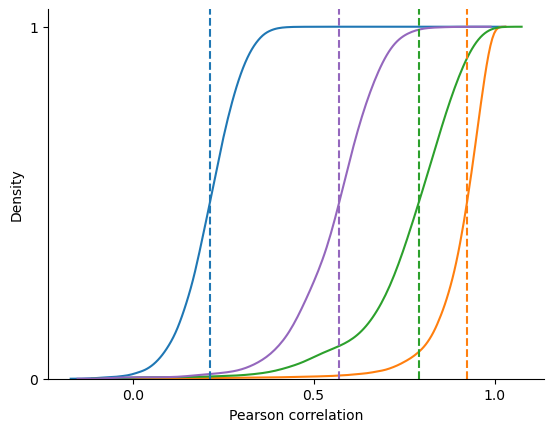

In [133]:
# Plot cdfs of pearson correlations (not used in paper, but here for completion's sake)

fig, d = plt.subplots()
sns.kdeplot(list(mean_predictor_corr.mean(axis=0)) + [1], cumulative=True)
sns.kdeplot(replicate_corr.values.reshape(-1), cumulative=True)
sns.kdeplot(clipnet.reshape(-1), cumulative=True)
sns.kdeplot(puffin.values.reshape(-1), color=colors[4], cumulative=True)
plt.axvline(np.nanmedian(mean_predictor_corr), 0, 1, color=colors[0], linestyle="--")
plt.axvline(np.nanmedian(replicate_corr), 0, 1, color=colors[1], linestyle="--")
plt.axvline(np.nanmedian(clipnet), 0, 1, color=colors[2], linestyle="--")
plt.axvline(np.nanmedian(puffin), 0, 1, color=colors[4], linestyle="--")
d.set_yticks([0, 1])
#d.set_yticklabels(["", ""])
d.set_xticks([0, 0.5, 1])
#d.set_xticklabels(["", "", ""])
d.set_ylabel("Density")
d.set_xlabel("Pearson correlation")
sns.despine()
plt.savefig("img/pearson_cdf.pdf")

PearsonRResult(statistic=0.6694969149740033, pvalue=0.0)
SignificanceResult(statistic=0.6352227045158337, pvalue=0.0)
[[0.36562596]]


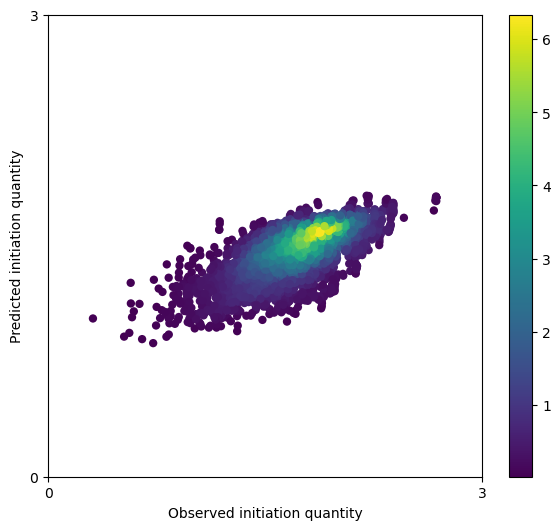

In [134]:
# Plot predicted vs observed log quantities

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
ax = sns.scatterplot(
    data=log_quantity,
    x="expt",
    y="clipnet",
    c=gaussian_kde(log_quantity.transpose())(log_quantity.transpose()),
    cmap="viridis",
    alpha=1,
    linewidth=0,
)
fig.colorbar(ax.collections[0], ax=ax, orientation="vertical")
ax.set_xlim(-0, 3)
ax.set_ylim(-0, 3)
ax.set_yticks([-0, 3])
#ax.set_yticklabels(["", ""])
ax.set_xticks([-0, 3])
#ax.set_xticklabels(["", ""])
ax.set_ylabel("Predicted initiation quantity")
ax.set_xlabel("Observed initiation quantity")
plt.savefig("img/log_quantity.pdf")

print(pearsonr(log_quantity.expt, log_quantity.clipnet))
print(spearmanr(log_quantity.expt, log_quantity.clipnet))
print(
    LinearRegression(fit_intercept=True).fit(
        log_quantity.expt.to_numpy().reshape(-1, 1),
        log_quantity.clipnet.to_numpy().reshape(-1, 1),
    ).coef_
)

/Users/adamhe/miniforge3/envs/plt/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/adamhe/miniforge3/envs/plt/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


PearsonRResult(statistic=0.8153807864702128, pvalue=0.0)


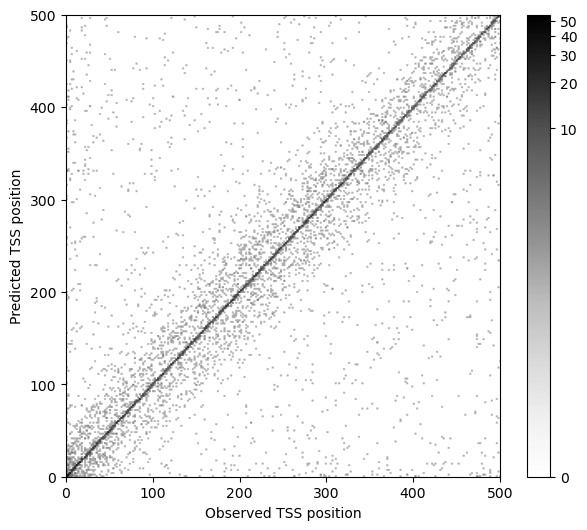

In [137]:
# Plot predicted vs observed TSS position (colored by log density)

norm = ImageNormalize(stretch=LogStretch())

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
log_density = ax.scatter_density(
    x=tss["expt"],
    y=tss["clipnet"],
    cmap="Greys",
    norm=norm,
)
fig.colorbar(log_density)
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
ax.set_ylabel("Predicted TSS position")
ax.set_xlabel("Observed TSS position")
plt.savefig("img/tss.pdf")

print(pearsonr(tss.expt, tss.clipnet))

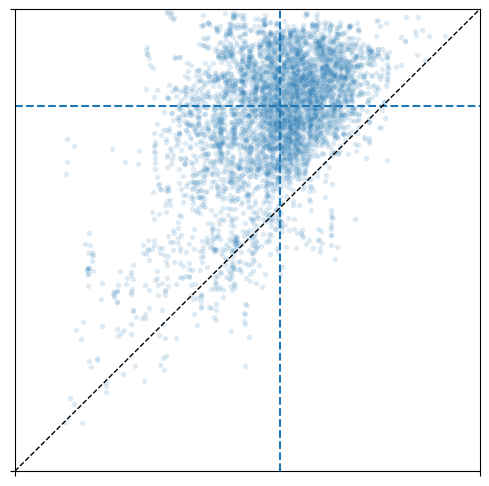

In [138]:
# Plot CLIPNET vs Puffin Pearson scatterplot

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
#density = ax.scatter_density(y=clipnet, x=puffin.values.flatten(), cmap=white_viridis)
density = sns.scatterplot(y=clipnet, x=puffin.values.flatten(), ax=ax, alpha=0.15, s=15, )
#fig.colorbar(density)
plt.axhline(np.nanmedian(clipnet), 0, 1, color=colors[0], linestyle="--")
plt.axvline(np.nanmedian(puffin), 0, 1, color=colors[0], linestyle="--")
# Add diagonal line
ax.plot([0, 1], [0, 1], color="black", linestyle="--", linewidth=1)
ax.set_xlim(-0, 1)
ax.set_ylim(-0, 1)
ax.set_yticks([-0, 1])
ax.set_yticklabels(["", ""])
ax.set_xticks([-0, 1])
ax.set_xticklabels(["", ""])
plt.savefig("img/puffin_comparison_pearson_scatterplot.pdf")